In [1]:
import os

import pandas as pd
import yaml

from src.dataPipeline import DataPipeline

os.chdir('..')

In [2]:

with open('src/params.yaml', 'r', encoding='utf-8') as file:
    params = yaml.safe_load(file)
    
columnsToDrop = params['columns_to_drop_all']

In [3]:

dp = DataPipeline()
dp.readCsv('data/immo_data_202208_v2.csv')

df = dp.data
feature_dummies =  df['features'].str.get_dummies(sep='\t')
df = pd.concat([df, feature_dummies], axis=1)
df = df.drop(columns=['features'])

dp.data = df

dp.dropColumns(columnsToDrop)

df = dp.data



for column in df.columns:
    if column not in ['Availability', 'type', 'provider', 'type_unified', 'detailed_description']:
        try:
            df[column] = df[column].astype(float)
        except:
            print(f'Error in column: {column}')
            break

df['Availability'] = df['Availability'].apply(
    lambda x: 'Future' if len(str(x).split('.')) > 1 else x
)
dp.data = df

dp.encodeCategoricalFeatures()
dp.standardize()
df = dp.data
scaler = dp.scaler
df = df.dropna(subset=['price_cleaned'])
df = df[df['price_cleaned'] > 10000]

C:\FHNW_Programmiersachen\5_Sem\immo_challenge\src\dataPipeline.py:46: DtypeWarning: Columns (3,4,5,6,11,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,45,46,47,49,50,107,110,114,115,116,119,120,121,124,125,126,128,131,132) have mixed types. Specify dtype option on import or set low_memory=False.
  self.data = pd.read_csv(filePath)


In [66]:
dp.readCsv('data/test_data-Kaggle-v0.11.csv')

df_kaggle = dp.data
feature_dummies =  df_kaggle['features'].str.get_dummies(sep='\t')
df_kaggle = pd.concat([df_kaggle, feature_dummies], axis=1)
df_kaggle = df_kaggle.drop(columns=['features'])

dp.data = df_kaggle

dp.dropColumns(columnsToDrop)

df_kaggle = dp.data

for column in df_kaggle.columns:
    if column not in ['Availability', 'type', 'provider', 'type_unified', 'detailed_description']:
        try:
            df_kaggle[column] = df_kaggle[column].astype(float)
        except:
            print(f'Error in column: {column}')
            break

df_kaggle['Availability'] = df_kaggle['Availability'].apply(
    lambda x: 'Future' if len(str(x).split('.')) > 1 else x
)

dp.data = df_kaggle

dp.encodeCategoricalFeatures()
dp.standardize()
df_kaggle = dp.data

C:\FHNW_Programmiersachen\5_Sem\immo_challenge\src\dataPipeline.py:46: DtypeWarning: Columns (3,4,5,6,11,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,45,46,48,49,104,111,112,115,116,117,120,121,122,124,127,128,130,131) have mixed types. Specify dtype option on import or set low_memory=False.
  self.data = pd.read_csv(filePath)


In [68]:
df_kaggle

,ForestDensityL,ForestDensityM,ForestDensityS,NoisePollutionRailwayL,NoisePollutionRailwayM,NoisePollutionRailwayS,NoisePollutionRoadL,NoisePollutionRoadM,NoisePollutionRoadS,PopulationDensityL,...,type_unified_rustico,type_unified_secondary-suite,type_unified_semi-detached-house,type_unified_single-room,type_unified_stepped-apartment,type_unified_stepped-house,type_unified_studio,type_unified_terrace-house,type_unified_villa,provider_homegate.ch
0,-0.119642,-0.134134,-0.094526,-0.363326,-0.385701,-0.244356,0.289880,-0.323378,-0.775804,0.466186,...,-0.055486,-0.00667,-0.200522,-0.011553,-0.098265,-0.053432,-0.065487,-0.156582,4.112560,-0.826644
1,0.362270,0.257641,0.025796,-0.409663,-0.385701,-0.244356,-0.076126,-0.559730,-0.831459,-0.024307,...,-0.055486,-0.00667,-0.200522,-0.011553,-0.098265,-0.053432,-0.065487,-0.156582,-0.243158,-0.826644
2,1.227741,1.301291,0.283799,-0.511931,-0.385701,-0.244356,-1.131383,-0.872784,0.227915,-0.559345,...,-0.055486,-0.00667,-0.200522,-0.011553,-0.098265,18.715385,-0.065487,-0.156582,-0.243158,-0.826644
3,-0.200522,-0.264458,-0.482560,-0.309447,-0.385701,-0.244356,0.144033,-0.014779,-0.337817,0.478268,...,-0.055486,-0.00667,-0.200522,-0.011553,-0.098265,-0.053432,-0.065487,6.386411,-0.243158,-0.826644
4,1.612684,0.903235,0.072539,-0.511931,-0.385701,-0.244356,-1.431614,-1.551220,-1.257445,-0.587153,...,-0.055486,-0.00667,-0.200522,-0.011553,-0.098265,-0.053432,-0.065487,6.386411,-0.243158,-0.826644
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24551,-0.007252,-0.586001,-0.482560,-0.511931,-0.385701,-0.244356,-1.018919,-0.979945,-1.294389,-0.991259,...,-0.055486,-0.00667,-0.200522,-0.011553,-0.098265,-0.053432,-0.065487,-0.156582,-0.243158,1.209711
24552,-0.234313,-0.670144,-0.411007,-0.511931,-0.385701,-0.244356,-0.937960,-0.658885,0.045301,-1.025927,...,-0.055486,-0.00667,-0.200522,-0.011553,-0.098265,-0.053432,-0.065487,-0.156582,-0.243158,1.209711
24553,-0.234313,-0.670144,-0.411007,-0.511931,-0.385701,-0.244356,-0.937960,-0.658885,0.045301,-1.025927,...,-0.055486,-0.00667,-0.200522,-0.011553,-0.098265,-0.053432,-0.065487,-0.156582,-0.243158,1.209711
24554,-0.234313,-0.670144,-0.411007,-0.511931,-0.385701,-0.244356,-0.937960,-0.658885,0.045301,-1.025927,...,-0.055486,-0.00667,-0.200522,-0.011553,-0.098265,-0.053432,-0.065487,-0.156582,-0.243158,1.209711


In [69]:
# find difference columns
dif = set(df.columns) - set(df_kaggle.columns)

In [70]:
dif

{'price_cleaned'}

In [73]:
from xgboost import XGBRegressor
from sklearn.model_selection import KFold
import numpy as np
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split



y = df['price_cleaned']
y_log = np.log(y)

scaler = dp.scaler
#y_log_scaled = scaler.fit_transform(y_log.values.reshape(-1, 1))

X = df.drop(columns=['price_cleaned'])


train_test_split_ratio = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=train_test_split_ratio)

model = XGBRegressor(objective='reg:squarederror', eval_metric='mape', n_estimators=50, learning_rate=0.05, max_depth=9, reg_lambda=0.5, reg_alpha=5, grow_policy='depthwise', min_split_loss=0.2, min_child_weight=2, subsample=0.9, max_bin=1024, tree_method = 'exact')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

#y_test = scaler.inverse_transform(y_test.reshape(-1, 1))
#y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))

y_test = np.exp(y_test)
y_pred = np.exp(y_pred)

mape = mean_absolute_percentage_error(y_test, y_pred) * 100
r2 = model.score(X_test, y_test)

print(f'Test MAPE: {mape:.3f}%, R2: {r2:.3f}')

# Train Mape
y_pred = model.predict(X_train)

#y_train = scaler.inverse_transform(y_train.reshape(-1, 1))
#y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))

y_train = np.exp(y_train)
y_pred = np.exp(y_pred)

mape = mean_absolute_percentage_error(y_train, y_pred) * 100
r2 = model.score(X_train, y_train)
print(f'Train MAPE: {mape:.3f}%, R2: {r2:.3f}')

Test MAPE: 28.478%, R2: -0.575
Train MAPE: 23.985%, R2: -0.587


In [15]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))
y_pred = np.exp(y_pred)

array([[5.0510675e+06],
       [1.6264734e+06],
       [1.4178550e+06],
       [1.6504788e+06],
       [1.3384920e+07],
       [2.1785882e+06],
       [1.3243089e+06],
       [1.4316804e+06],
       [2.7592175e+06],
       [2.5999970e+06],
       [1.2343986e+06],
       [2.1107872e+06],
       [2.7656242e+06],
       [1.3967226e+06],
       [2.7780405e+06],
       [6.1974670e+06],
       [1.0152288e+06],
       [2.0252796e+06],
       [2.3075462e+06],
       [2.1131740e+06],
       [2.1225052e+06],
       [1.5375821e+06],
       [2.6366530e+06],
       [4.6090230e+09],
       [1.2416242e+06],
       [6.7835035e+06],
       [1.4875921e+06],
       [1.8325778e+06],
       [1.6920642e+07],
       [1.4099345e+06],
       [1.2475642e+07],
       [2.3320765e+06],
       [3.6530310e+06],
       [1.3770961e+06],
       [3.0507402e+06],
       [3.0974074e+07],
       [1.4420314e+06],
       [2.0266939e+06],
       [1.6022411e+06],
       [2.2562188e+06],
       [1.7149634e+06],
       [1.317274

In [21]:
y_train = scaler.inverse_transform(y_train.reshape(-1, 1))
y_train = np.exp(y_train)
y_train

array([[ 2499951.89834472],
       [ 1283135.06298695],
       [ 1706272.57362156],
       ...,
       [ 1807412.07908947],
       [19999541.77509988],
       [ 1218557.55971929]])

In [72]:
from src.utils.helperFunctions import create_kaggle_results

results = model.predict(df_kaggle)
#results = scaler.inverse_transform(results.reshape(-1, 1))
results = np.exp(results)
create_kaggle_results(results, csv_name='xgBoost_unclean_data_with_much_regul')

File xgBoost_unclean_data_with_much_regul_2024-12-26_16-44-46.csv created successfully.


C:\FHNW_Programmiersachen\5_Sem\immo_challenge\src\utils\helperFunctions.py:13: DtypeWarning: Columns (3,4,5,6,11,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,45,46,48,49,104,111,112,115,116,117,120,121,122,124,127,128,130,131) have mixed types. Specify dtype option on import or set low_memory=False.
  indexes = pd.read_csv(path_to_kaggledata)['Unnamed: 0']


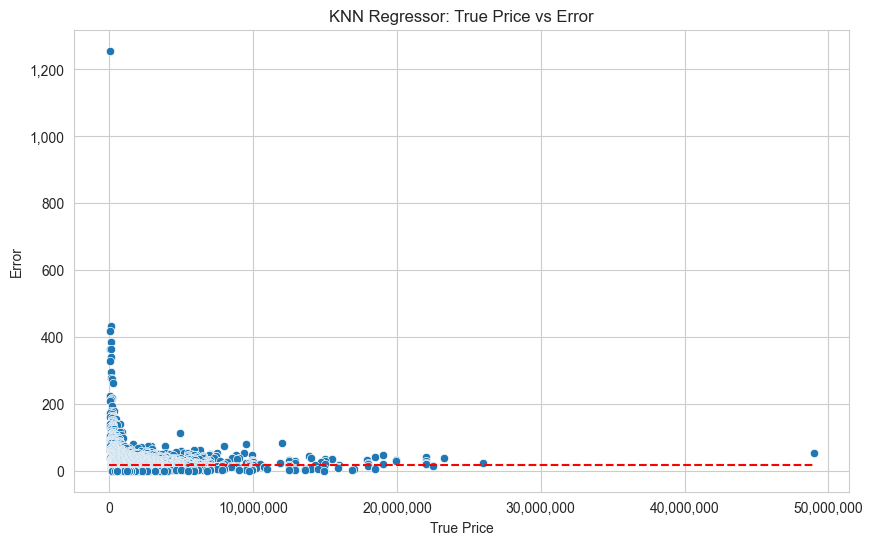

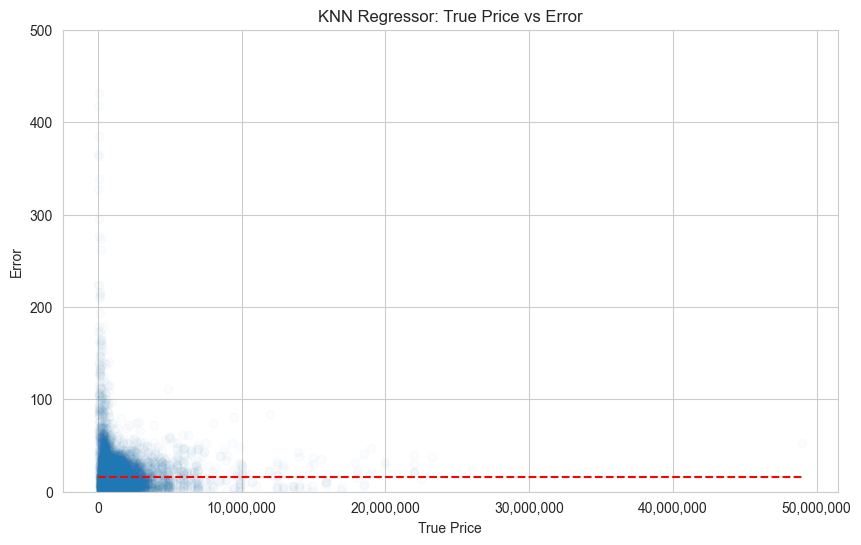

In [20]:
from src.utils.helperFunctions import analyse_highest_errors
import matplotlib.pyplot as plt
import seaborn as sns

y_pred = model.predict(X_train)
#y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))


y_pred = np.exp(y_pred)


mape = mean_absolute_percentage_error(y_train, y_pred) * 100
error_analysis = X_train.copy()
error_analysis['predicted_price'] = y_pred
error_analysis['true_price'] = y_train
error_analysis['mape'] = np.abs(error_analysis['true_price'] - error_analysis['predicted_price']) / error_analysis['true_price'] * 100
error_analysis = error_analysis.sort_values(by='mape', ascending=False)
# Plot price vs error
import matplotlib.ticker as ticker

plt.figure(figsize=(10, 6))
sns.scatterplot(x=error_analysis['true_price'], y=error_analysis['mape'])
plt.xlabel('True Price')
plt.ylabel('Error')
plt.gca().xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))  # Format x-axis
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))  # Format y-axis
plt.title('KNN Regressor: True Price vs Error')
plt.hlines(y=mape, xmin=0, xmax=error_analysis['true_price'].max(), color='red',
           linestyles='dashed')
plt.show()
plt.figure(figsize=(10, 6))
plt.scatter(x=error_analysis['true_price'], y=error_analysis['mape'], alpha=0.02)
plt.xlabel('True Price')
plt.ylabel('Error')
plt.gca().xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))  # Format x-axis
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))  # Format y-axis
plt.ylim(0, 500)
plt.title('KNN Regressor: True Price vs Error')

plt.hlines(y=mape, xmin=0, xmax=error_analysis['true_price'].max(), color='red',
           linestyles='dashed')
plt.show()

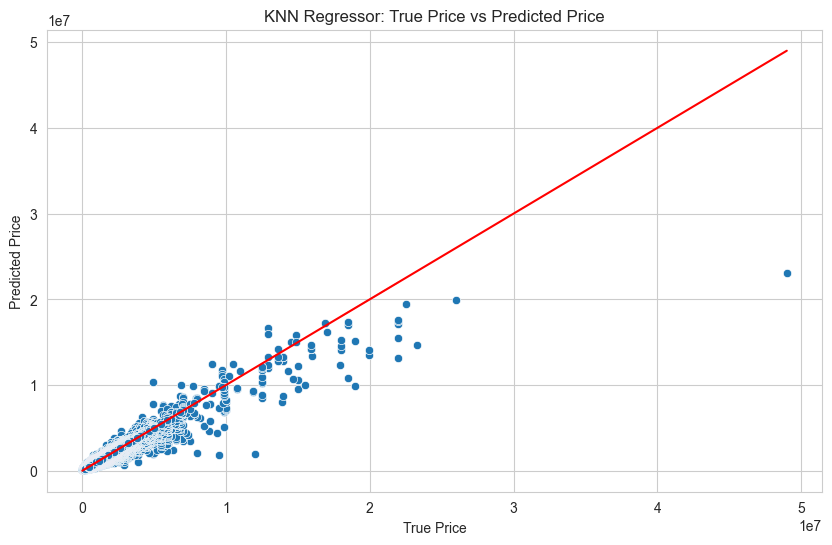

In [26]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=error_analysis['true_price'], y=error_analysis['predicted_price'])
sns.lineplot(x=error_analysis['true_price'], y=error_analysis['true_price'], color='red')
plt.xlabel('True Price')
plt.ylabel('Predicted Price')
plt.title('KNN Regressor: True Price vs Predicted Price')
plt.show()

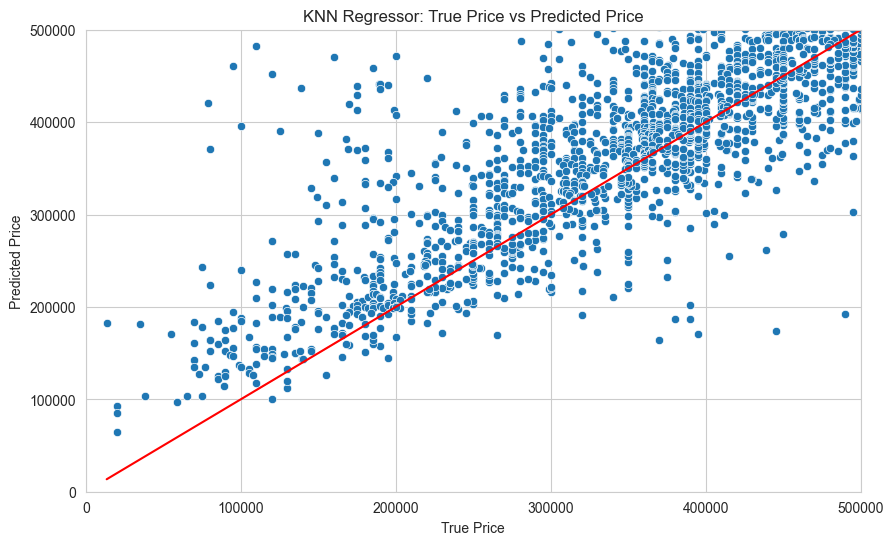

In [29]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=error_analysis['true_price'], y=error_analysis['predicted_price'])
sns.lineplot(x=error_analysis['true_price'], y=error_analysis['true_price'], color='red')
plt.xlabel('True Price')
plt.ylabel('Predicted Price')
plt.title('KNN Regressor: True Price vs Predicted Price')
plt.ylim(0, 500000)
plt.xlim(0, 500000)
plt.show()

# KNN

In [1]:
import os

import pandas as pd
import yaml

from src.dataPipeline import DataPipeline

os.chdir('..')

with open('src/params.yaml', 'r', encoding='utf-8') as file:
    params = yaml.safe_load(file)

columnsToDrop = params['columns_to_drop_all']

dp = DataPipeline()
dp.readCsv('data/immo_data_202208_v2.csv')

df = dp.data
feature_dummies = df['features'].str.get_dummies(sep='\t')
df = pd.concat([df, feature_dummies], axis=1)
df = df.drop(columns=['features'])

dp.data = df

dp.dropColumns(columnsToDrop)

df = dp.data

for column in df.columns:
    if column not in ['Availability', 'type', 'provider', 'type_unified', 'detailed_description']:
        try:
            df[column] = df[column].astype(float)
        except:
            print(f'Error in column: {column}')
            break

df['Availability'] = df['Availability'].apply(
    lambda x: 'Future' if len(str(x).split('.')) > 1 else x
)
dp.data = df

dp.encodeCategoricalFeatures()
dp.standardize()
df = dp.data
scaler = dp.scaler
df = df.dropna(subset=['price_cleaned'])
df = df[df['price_cleaned'] > 10000]

# Imputer
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=5, weights='distance')
df_imputed = imputer.fit_transform(df.copy())
df_imputed = pd.DataFrame(df_imputed, columns=df.columns)

C:\FHNW_Programmiersachen\5_Sem\immo_challenge\src\dataPipeline.py:46: DtypeWarning: Columns (3,4,5,6,11,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,45,46,47,49,50,107,110,114,115,116,119,120,121,124,125,126,128,131,132) have mixed types. Specify dtype option on import or set low_memory=False.
  self.data = pd.read_csv(filePath)


In [3]:
df_imputed

,ForestDensityL,ForestDensityM,ForestDensityS,NoisePollutionRailwayL,NoisePollutionRailwayM,NoisePollutionRailwayS,NoisePollutionRoadL,NoisePollutionRoadM,NoisePollutionRoadS,PopulationDensityL,...,type_unified_rustico,type_unified_secondary-suite,type_unified_semi-detached-house,type_unified_single-room,type_unified_stepped-apartment,type_unified_stepped-house,type_unified_studio,type_unified_terrace-house,type_unified_villa,provider_homegate.ch
0,1.612684,0.903235,0.072539,-0.511931,-0.385701,-0.244356,-1.431614,-1.551220,-1.257445,-0.587153,...,-0.055486,-0.00667,-0.200522,-0.011553,-0.098265,-0.053432,-0.065487,-0.156582,-0.243158,-0.826644
1,1.612684,0.903235,0.072539,-0.511931,-0.385701,-0.244356,-1.431614,-1.551220,-1.257445,-0.587153,...,-0.055486,-0.00667,-0.200522,-0.011553,-0.098265,-0.053432,-0.065487,6.386411,-0.243158,-0.826644
2,-0.124736,-0.157240,-0.470891,-0.511931,-0.385701,-0.244356,0.788090,0.955172,0.066983,1.076233,...,-0.055486,-0.00667,-0.200522,-0.011553,-0.098265,-0.053432,-0.065487,-0.156582,-0.243158,-0.826644
3,1.612684,0.903235,0.072539,-0.511931,-0.385701,-0.244356,-1.431614,-1.551220,-1.257445,-0.587153,...,-0.055486,-0.00667,-0.200522,-0.011553,-0.098265,-0.053432,-0.065487,-0.156582,-0.243158,-0.826644
4,0.726969,0.863309,0.407935,-0.511931,-0.385701,-0.244356,-0.828264,-1.025663,-0.354546,0.113062,...,-0.055486,-0.00667,-0.200522,-0.011553,-0.098265,-0.053432,-0.065487,-0.156582,-0.243158,-0.826644
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21439,1.535455,1.456550,0.111435,-0.511931,-0.385701,-0.244356,-0.001742,0.572635,0.800212,-0.450109,...,-0.055486,-0.00667,-0.200522,-0.011553,-0.098265,-0.053432,-0.065487,-0.156582,-0.243158,1.209711
21440,-0.940771,-0.690764,-0.482560,-0.511931,-0.385701,-0.244356,0.713096,0.983071,1.269908,1.127705,...,-0.055486,-0.00667,-0.200522,-0.011553,10.176581,-0.053432,-0.065487,-0.156582,-0.243158,1.209711
21441,-0.940771,-0.690764,-0.482560,1.539447,2.157461,0.459541,0.561866,0.402426,-0.260984,1.153635,...,-0.055486,-0.00667,-0.200522,-0.011553,-0.098265,-0.053432,-0.065487,-0.156582,-0.243158,1.209711
21442,1.111498,0.151517,-0.248385,-0.511931,-0.385701,-0.244356,-0.310220,0.062891,0.127784,-0.761983,...,-0.055486,-0.00667,-0.200522,-0.011553,10.176581,-0.053432,-0.065487,-0.156582,-0.243158,1.209711


In [ ]:
# Import necessary libraries
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_percentage_error

df = df_imputed

y = df['price_cleaned']
y_log = np.log(y)
#y_log = y

X = df.drop(columns=['price_cleaned'])


train_test_split_ratio = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=train_test_split_ratio)


# Initialize KNN Regressor
model = KNeighborsRegressor(n_neighbors=5, algorithm='kd_tree', weights='distance', p=10)  # Use 5 neighbors

# Train the model
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

y_test = np.exp(y_test)
y_pred = np.exp(y_pred)

mape = mean_absolute_percentage_error(y_test, y_pred) * 100

print(f'Test MAPE: {mape:.3f}%')

# Train Mape
y_pred = model.predict(X_train)
y_train = np.exp(y_train)
y_pred = np.exp(y_pred)

mape = mean_absolute_percentage_error(y_train, y_pred) * 100

print(f'Train MAPE: {mape:.3f}%')

Test MAPE: 42.948%
